# 聚类

聚类分析是一种无监督学习法，它将数据点分离成若干个特定的群或组，使得在某种意义上同一组中的数据点具有相似的性质，不同组中的数据点具有不同的性质。

聚类分析包括基于不同距离度量的多种不同方法。例如。K均值（点之间的距离）、Affinity propagation（图之间的距离）、均值漂移（点之间的距离）、DBSCAN（最近点之间的距离）、高斯混合（到中心的马氏距离）、谱聚类（图之间距离）等。

所有聚类法都使用相同的方法，即首先计算相似度，然后使用相似度将数据点聚类为组或群。

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## 介绍K-Means

K-means是一个无监督聚类的算法，也就是它根据数据本身的属性来将数据划分成不同的类别（而不是根据给定的标签）。

K-means是一个相对来说比较容易理解的算法。它每次都会根据数据的分布去寻找聚类中心。每一个点都被划分为不同的分类，每一个点与自己类别的中心在距离上都是最近的。
![Data Layout](images/kmeans.jpg)

我们来看一看KMeans在简单的数据分布中是如何运作的。我们将用不同颜色去给不同类别的点上色。

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


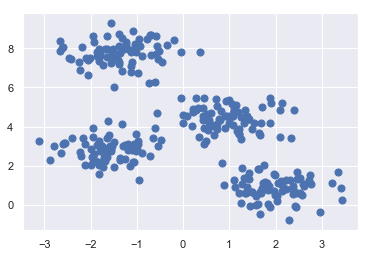

In [2]:
from sklearn.datasets.samples_generator import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], s=50);

我们肉眼就可以看出这个数据集合的四个分类。如果您需要对这些数据做一个十分详尽的划分的话，需要的搜索空间将会是指数级别的。幸运的是，scikit-learn实现了一个众所周知的*最大期望 (Expectation Maximization)*过程，以至于上述问题可以非常快的解决。

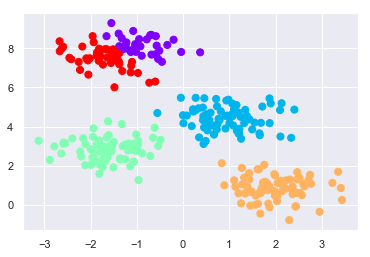

In [5]:
from sklearn.cluster import KMeans

est = KMeans(5)   # 4个聚类 这个如何指定？看后面提到的两个指标
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow');

**肘部法则–Elbow Method**

我们知道k-means是以最小化样本与质点平方误差作为目标函数，将每个簇的质点与簇内样本点的平方距离误差和称为畸变程度(distortions)，那么，对于一个簇，它的畸变程度越低，代表簇内成员越紧密，畸变程度越高，代表簇内结构越松散。 畸变程度会随着类别的增加而降低，但对于有一定区分度的数据，在达到某个临界点时畸变程度会得到极大改善，之后缓慢下降，这个临界点就可以考虑为聚类性能较好的点。

In [6]:
print('Distortion: %.2f' % est.inertia_) 
#是K-Means模型对象的属性，它作为没有真实分类结果标签下的非监督式评估指标。
#表示样本到最近的聚类中心的距离总和。值越小越好，越小表示样本在类间的分布越集中。

Distortion: 188.83


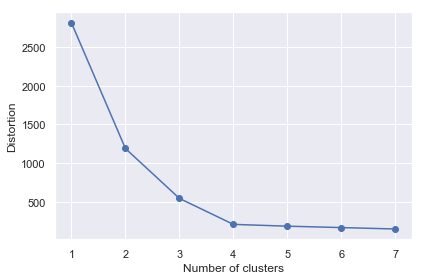

In [7]:
distortions = []
for i in range(1, 8):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_) 
plt.plot(range(1, 8), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

**轮廓系数–Silhouette Coefficient**

对于一个聚类任务，我们希望得到的簇中，簇内尽量紧密，簇间尽量远离，轮廓系数便是类的密集与分散程度的评价指标，公式表达如下： s=b−amax(a,b)s=b−amax(a,b) 其中a代表同簇样本到彼此间距离的均值，b代表样本到除自身所在簇外的最近簇的样本的均值，s取值在[-1, 1]之间。 如果s接近1，代表样本所在簇合理，若s接近-1代表s更应该分到其他簇中。

判断： 轮廓系数范围在[-1,1]之间。该值越大，越合理。 si接近1，则说明样本i聚类合理； si接近-1，则说明样本i更应该分类到另外的簇； 若si 近似为0，则说明样本i在两个簇的边界上。 所有样本的s i 的均值称为聚类结果的轮廓系数，是该聚类是否合理、有效的度量。 使用轮廓系数(silhouette coefficient)来确定，选择使系数较大所对应的k值

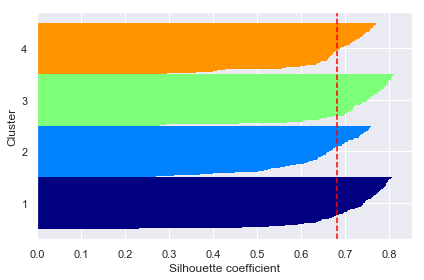

In [9]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=4,    
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
# plt.savefig('./figures/silhouette.png', dpi=300)
plt.show()

### 关于KMeans的警告

KMeans并不能保证最后的结果一定是收敛的。所以，scikit-learn初始化了很多随机值，去寻找最优的结果。

同时，需要进行的分类类别个数必须事先确定。对于一些其他的聚类算法，类别的个数可以事先确定。

K-Means的局限性：

 （1）当聚类的大小、密度、形状不同时，K-means 聚类的结果不理想

 （2）数据集包含离群点时，K-means 聚类结果不理想

 （3）两个类距离较近时，聚类结果不合理

## 介绍DBSCAN
本文将重点介绍具有噪声的基于密度的聚类方法（DBSCAN  Density-Based Spatial Clustering of Applications with Noise）。

既然已经有了K均值聚类，为什么还需要DBSCAN这样的基于密度的聚类算法呢？

K均值聚类可以将松散相关的观测聚类在一起。每一个观测最终都成为某个聚类的一部分，即使这些观测在向量空间中分散得很远。由于聚类依赖于聚类元素的均值，因此每个数据点在形成聚类中都起着作用。

数据点的轻微变化可能会影响聚类结果。由于聚类的形成方式，这个问题在DBSCAN中大大减少。这通常不是什么大问题，除非遇到一些具有古怪形状的数据。

使用K均值的另一个困难是需要指定聚类的数量（“k”）以便使用。很多时候不会预先知道什么是合理的k值。

DBSCAN的优点在于，不必指定使用它的聚类数量。需要的只是一个计算值之间距离的函数，以及一些将某些距离界定为“接近”的指令。在各种不同的分布中，DBSCAN也比K均值产生更合理的结果。下图说明了这一事实:

![Data Layout](images/kmeandbscan.jpeg)

具有噪声的基于密度的聚类方法(DBSCAN)是基于密度聚类的一种基本算法。它可以从大量的数据中发现不同形状和大小的聚类，这些聚类中正包含着噪声和异常值。

DBSCAN算法使用以下两种参数：

· eps (ε)：一种距离度量，用于定位任何点的邻域内的点。

· minPts：聚类在一起的点的最小数目（一个阈值），使一个区域界定为密集。

如果探究两个称为密度可达性（DensityReachability）和密度连接性（DensityConnectivity）的概念，就可以理解这些参数。

密度方面的可达性（Reachability）建立了一个可以到达另一个点的点，如果该点位于与另一个点的特定距离（eps）内。

连接性（Connectivity）涉及到基于传递性的链接方法，以确定点是否位于特定的聚类中。例如，如果p->r->s->t->q，则p和q可以连接，其中a->b表示b在a的邻域内。

DBSCAN聚类完成后会产生三种类型的点：

· 核心点（Core）——该点表示至少有m个点在距离n的范围内。

· 边界点（Border） ——该点表示在距离n处至少有一个核心。

· 噪声点（Noise） ——它既不是核心点也不是边界点。并且它在距离自身n的范围内有不到m个点。

![Data Layout](images/dbscan.jpeg)

DBSCAN聚类算法步骤

1. 算法通过任意选取数据集中的一个点（直到所有的点都访问到）来运行。

2. 如果在该点的“ε”半径范围内至少存在“minPoint”点，那么认为所有这些点都属于同一个聚类。

3. 通过递归地重复对每个相邻点的邻域计算来扩展聚类

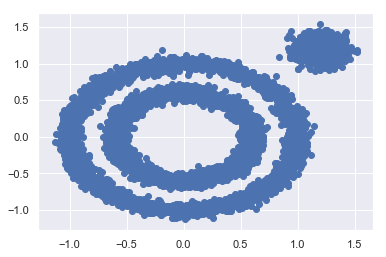

In [10]:
#采用基于密度的聚类DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
%matplotlib inline
X1, y1=datasets.make_circles(n_samples=5000, factor=.6,
                                      noise=.05)
X2, y2 = datasets.make_blobs(n_samples=1000, n_features=2, centers=[[1.2,1.2]], cluster_std=[[.1]],
               random_state=9)

X = np.concatenate((X1, X2))
plt.scatter(X[:, 0], X[:, 1], marker='o')
plt.show()

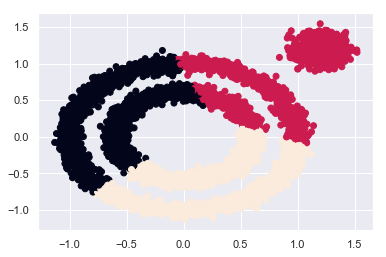

In [11]:
from sklearn.cluster import KMeans
y_pred = KMeans(n_clusters=3, random_state=9).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

DBSCAN算法使用以下3种参数：

eps：两个样本被看作邻居节点的最大距离。

min_sample：簇的样本数。

metric：距离计算方式。

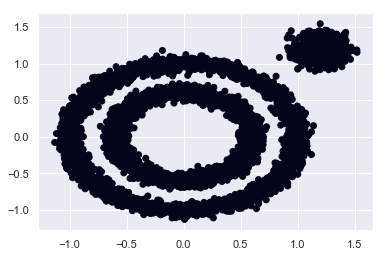

In [12]:
from sklearn.cluster import DBSCAN
y_pred = DBSCAN().fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

怎么办？看来我们需要对DBSCAN的两个关键的参数eps和min_samples进行调参！从上图我们可以发现，类别数太少，我们需要增加类别数，那么我们可以减少ϵ-邻域的大小，默认是0.5，我们减到0.1看看效果。代码如下：

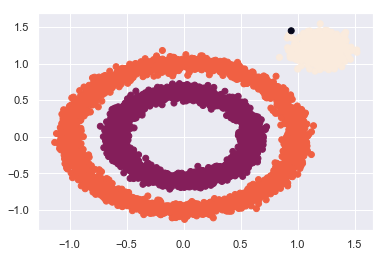

In [13]:
y_pred = DBSCAN(eps = 0.1, min_samples = 10).fit_predict(X) 
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

从图中，我们可以看到这个算法划分出的数据集合和我们肉眼划分的几乎一模一样！

### DBSCAN的问题
DBSCAN对用户定义的参数很敏感，细微的不同都可能导致差别很大的结果，而超参数的选择无规律可循，只能靠经验确定。

## KMeans 在手写数字识别上的应用

我们来看一个更贴近生活的例子，也就是我们在前几章都有提及过的手写数字的识别。在这里，我们运用Kmeans算法将64维的手写数字数据自动的分成10类，我们接下来看一看Kmeans算法有怎样的效果。

In [15]:
KMeans?

In [16]:
from sklearn.datasets import load_digits

digits = load_digits()

In [17]:
est = KMeans(n_clusters=10)
clusters = est.fit_predict(digits.data)
est.cluster_centers_.shape #类别的中心点


(10, 64)

我们可以看到现在64维的数据已经被分为了10类。我们来看一看这10个中心分别代表着什么。

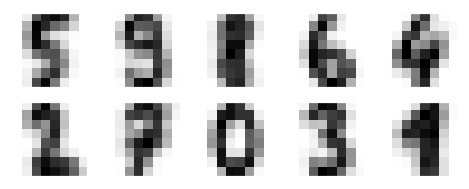

In [18]:
fig = plt.figure(figsize=(8, 3))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.imshow(est.cluster_centers_[i].reshape((8, 8)), cmap=plt.cm.binary)

我们看到，即使*没有之前给定的标签*。KMeans算法也可以很好的找到数字的分类的中心。


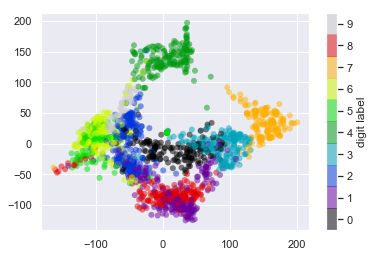

In [19]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)#另外一种降维的方法
data_projected = iso.fit_transform(digits.data)
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=clusters,
            edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10));
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5)

聚类算法应用案例：https://zhuanlan.zhihu.com/p/59755144